# Assignment 2
### Elizabeth Perry | 32968302

The core technical ideas of this code are adapted from the material presented in the Week 8 and Week 9 tutorial. This was predominantly a concession to the logistical difficulties of training using batched Dataloaders when handling varied sequence lengths - attempts to use packed padded sequences proved to carry too much technical burden to be within scope of the assignment. This does mean that I cannot conduct training on as many iterations of the data as I would like, but ultimately the results are still interesting to evaluate.


In [2]:
#Generic imports and OS settings
import os
import csv
import glob
import matplotlib
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #useful in testing to prevent model compile issues

In [3]:
## Requirements
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from tqdm import trange
import torch
import nltk 
import numpy as np

#Other imports
from numpy import transpose
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate import meteor
from nltk.corpus import stopwords



In [4]:
# boilerplate declaration of hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_forcing_ratio = 1
ITERCOUNT = 60000
MAX_LENGTH = 150 


# Data Loading and Preprocessing

Transforming one sequence to another is possible by the simple but powerful idea of the [sequence to sequence network](https://arxiv.org/abs/1409.3215), in which two recurrent neural networks work. An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

![seq2seq](https://pytorch.org/tutorials/_images/seq2seq.png)

### Language Class

The language is a useful helper tool to convert from word string space to word vector space. Every word simply has a numerical index in the language and can thus be represented as a one-hot vector. Lang exposes methods to easily convert between word and vector space, as well as methods to check whether the word is registered in the language, and to add sentences worth of words to the language.

In [5]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def stoi(self, word): # helper method to convert string to index
        return self.word2index[word]
    
    def itos(self, ndx): # helper method to convert indexes to string
        return self.index2word[ndx]
    
    def contains(self, word):
        if word in self.word2index:
            return True
        return False

Helper method to trim unwanted characters and standardise strings. Also converts unicode data to Ascii data for this purpose.

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

## RECIPE DATA PROCESSING

The recipe processing pipeline is as follows: 
1. process raw text extracts recipe pairs from the raw text folders by calling text-to-recipe.
2. text-to-recipe uses regex capture groups to crawl the recipe file string and extract the recipe steps along with ingredients lists as matched pairs
3. recipes are cleaned up with data normalisation, stopword removal, and preprocessing
4. write-tsv writes recipes into new .tsv files

these TSV files are our new data

5. extract pairs pulls the data from the tsv files
6. the pairs are passed into build-language
7. the remaining objects will be three lists (one each for training, dev, and test sets) along with two Lang type objects (one for the ingredients language, and the other for the recipe language)

In [7]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
measurements = {"c", "tsp", "tbsp", "qt", "cn", "lb", "ts", "ea", "lg", "tb"}
stop_words.update(measurements)


def trim_stopwords(text):
    output = " ".join([word for word in str(text).split() if word not in stop_words])
    output = output.lower()
    return output

def recipe_cleanup(all_recipes):
    outputs = []
    for recipe in all_recipes:
        clean_ing = trim_stopwords(recipe[0])
        clean_step = trim_stopwords(recipe[1])
        outputs.append((clean_ing, clean_step))
    return outputs

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def text_to_recipe_processing(line):
    title = re.findall(r'Title: (.*)', line)
    ingredients = re.findall(r'ingredients: (.*)', line)
    steps = re.findall(r'ingredients: .*\n([\s\S]*)', line)
    try:
        title = title[0]
        title = re.sub(r'[^a-zA-Z ]', '', title) #remove non-alpha or underscore characters
        title = re.sub(r'\s+', ' ', title) #remove excess spaces
        ingredients = ingredients[0].replace('''\t''', " ") #replace tab with space for better formatting
        ingredients = re.sub(r'[^a-zA-Z ]', '', ingredients)
        ingredients = re.sub(r'\s+', ' ', ingredients)
        steps = steps[0].replace('''\n''', " ") #replace newline in steps with space
        steps = re.sub(r'[^a-zA-Z ]', '', steps)
        steps = re.sub(r'\s+', ' ', steps)
    except:
        return None
    return (str(title + " " + ingredients), str(steps))

def process_rawtext(path):
    print("Processing text data from {}".format(path))
    recipes = []
    files = glob.glob(path + "/*.txt")
    for file in files:
        lines = open(file, encoding='utf-8').read().strip().split("END RECIPE")
        for l in lines:
            recipe = text_to_recipe_processing(l)
            if recipe is not None:
                recipes.append(recipe)
    return recipes

def write_to_tsv(destination, recipe_list):
    with open(destination, 'w',  newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        for recipe in recipe_list:
            writer.writerow(recipe)

def build_language(data_paths):
    all_ingredients = []
    all_recipes = []
    for path in data_paths: #manual path list:
        recipes = extract_pairs(path)
        for r in recipes:
            all_ingredients.append(r[0])
            all_recipes.append(r[1])
    ingredient_lang = Lang("ingredients")
    recipe_lang = Lang("recipes")
    for ing in all_ingredients:
        ingredient_lang.addSentence(ing)
    for rec in all_recipes:
        recipe_lang.addSentence(rec)
    return ingredient_lang, recipe_lang


In [7]:

###Recipes without stopwords
# Only run this cell to re-process the data.
train_recipes = process_rawtext("Cooking_Dataset/train")
cleaned_train = recipe_cleanup(train_recipes)
write_to_tsv("Clean_Data/train.tsv", cleaned_train)
dev_recipes = process_rawtext("Cooking_Dataset/dev")
cleaned_dev = recipe_cleanup(dev_recipes)
write_to_tsv("Clean_Data/dev.tsv", cleaned_dev)
test_recipes = process_rawtext("Cooking_Dataset/test")
cleaned_test = recipe_cleanup(test_recipes)
write_to_tsv("Clean_Data/test.tsv", cleaned_test)

Processing text data from Cooking_Dataset/train
Processing text data from Cooking_Dataset/dev
Processing text data from Cooking_Dataset/test


Pairs can be later extracted from the .tsv files and returned as recipes, after being filtered for passing max length and the strings normalised (just in case any stray data makes it through the cleanup phase)

In [9]:
#Filter pairs only for those below max length.

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def extract_pairs(path):
    all_recipes = []
    file = open(path, 'r')
    lines = file.readlines()
    for l in lines:
        items = [normalizeString(s) for s in l.split("""\t""")]
        all_recipes.append(items)
    all_recipes = filterPairs(all_recipes)
    return all_recipes

In [10]:
## Final data preparation

dataset_path = ["Clean_Data/train.tsv", "Clean_Data/dev.tsv", "Clean_Data/test.tsv"]
input_lang, output_lang = build_language(dataset_path)
pairs = extract_pairs("Clean_Data/train.tsv")
dev_pairs = extract_pairs("Clean_Data/dev.tsv")
test_pairs = extract_pairs("Clean_Data/test.tsv")

#### Data Summary Statistics

In [79]:
def pair_summary_stats(pairs, name):
    ingredients = [pairs[i][0] for i in range(len(pairs))]
    recipes = [pairs[i][1] for i in range(len(pairs))]
    ingredient_stats = [len(r) for r in ingredients]
    recipe_stats = [len(r) for r in recipes]
    ing_stats = summary_statistics(ingredient_stats)
    rec_stats = summary_statistics(recipe_stats)
    print("Number of samples in {} set: {}".format(name, len(pairs)))
    print("Maximum length of ingredients from {} set: {}".format(name, ing_stats[0]))
    print("Minimum length of ingredients from {} set: {}".format(name, ing_stats[1]))
    print("Mean length of ingredients from {} set: {}".format(name, ing_stats[2]))
    print("Maximum length of recipes from {} set: {}".format(name, rec_stats[0]))
    print("Minimum length of recipes from {} set: {}".format(name, rec_stats[1]))
    print("Mean length of recipes from {} set: {}".format(name, rec_stats[2]))
    print("###")

def summary_statistics(input_list):
    l_max = max(input_list)
    l_min = min(input_list)
    l_mean = sum(input_list)/len(input_list)
    return (l_max, l_min, l_mean)

In [80]:
print("Length of ingredients corpus: {}".format(input_lang.n_words))
print("Length of recipes corpus: {}".format(output_lang.n_words))
print("######")
pair_summary_stats(pairs, "train")
pair_summary_stats(dev_pairs, "validation")
pair_summary_stats(test_pairs, "test")

Length of ingredients corpus: 32496
Length of recipes corpus: 34141
######
Number of samples in train set: 55848
Maximum length of ingredients from train set: 988
Minimum length of ingredients from train set: 11
Mean length of ingredients from train set: 174.76840710499928
Maximum length of recipes from train set: 1131
Minimum length of recipes from train set: 0
Mean length of recipes from train set: 338.1704805901733
###
Number of samples in validation set: 281
Maximum length of ingredients from validation set: 568
Minimum length of ingredients from validation set: 18
Mean length of ingredients from validation set: 164.60142348754448
Maximum length of recipes from validation set: 970
Minimum length of recipes from validation set: 5
Mean length of recipes from validation set: 319.55160142348757
###
Number of samples in test set: 300
Maximum length of ingredients from test set: 462
Minimum length of ingredients from test set: 33
Mean length of ingredients from test set: 166.25
Maximum l

### MODEL DEFINITION - MODEL ONE

Model One is a vanilla Seq2Seq neural network consisting of an encoder and a decoder working in concert to convert from one sequence space to the other. Each recurrent block in the Encoder consists of an input layer, and an embedding layer, which pass inputs to an LSTM. The LSTM passes along an output state, a hidden state, and a cell state (relevant for the "forget" gate in the LSTM's memory system). The final output of the Encoder will be the context vector, representing the 'context' of the previous input space.

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder works in a similar fashion.

In [26]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        output = self.softmax(self.out(output[0]))
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


#### Preparing Training data

One final step of preprocessing is needed before we can start the model training - we need to pass the word vectors in to torch tensors on the correct device. These helper functions enable that process at scale.

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#### Training the Model

The model is trained by passing in an input sentence, converting them to tensors, and then passing the encoder's states through each step of the sentence. The process is repeated for the decoder, and NLLLoss checked at each decoding step.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster [but when the trained network is exploited, it may exhibit instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf). Here, since the teacher forcing ratio is set to 1, the model's outputs will always be teacher forced.

In [69]:
teacher_forcing_ratio = 1


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder_hidden

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(
            input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = decoder_hidden

    use_teacher_forcing = True 
    # if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(
                decoder_input, decoder_hidden, decoder_cell)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


### Plotting Helper Fn

In [70]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
    
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

A validation function to calculate validation loss using torch.no_grad()



In [129]:
def validate(encoder, decoder, target_tensor, input_tensor, criterion, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder_hidden
        loss = 0

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(
                input_tensor[ei], encoder_hidden, encoder_cell)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = decoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(
                decoder_input, decoder_hidden, decoder_cell)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            try:
                loss += criterion(decoder_output, target_tensor[di])
            except:
                break
            decoder_input = topi.squeeze().detach()
        if type(loss) == int:
            return 0
        return loss.item()/len(decoded_words)


The training process is as follows:
1. Declare empty arrays to store plot and validation losses
2. Declare new encoder and decoder optimisers, pass training and validation sets into pairs
3. Using tqdm to time, iterate through training set calling train.
4. Check validation set on plot_every iterations
5. Print diagnostics where applicable

In [142]:
def trainIters(encoder, decoder, n_iters, input_lang, output_lang, val_data, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    val_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    val_loss_total = 0
    skipped = 0 #In some cases, validation will fail to return a loss at all due to no text being generated - I skip over this input and track skipped validation data.

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang)
                      for i in range(n_iters)]
    validation_pairs = [tensorsFromPair(random.choice(val_data), input_lang, output_lang)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in trange(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        val_pair = random.choice(validation_pairs) #This will also cause a crash when we get OOB :(
        val_target = val_pair[1]
        val_input = val_pair[0]
        val = validate(encoder, decoder, val_target, val_input, criterion, MAX_LENGTH)
        if val == 0:
            skipped += 1
        if val > 0:
            val_loss_total += val

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("Loss: {}".format(print_loss_avg))

        if iter % plot_every == 0:
            val_loss_avg = val_loss_total/(plot_every - skipped)
            val_losses.append(val_loss_avg)
            val_loss_total = 0
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            skipped = 0
    torch.save(encoder.state_dict(), "Checkpoints/Vanilla/encoder{}.pt".format(n_iters))
    torch.save(decoder.state_dict(), "Checkpoints/Vanilla/decoder{}.pt".format(n_iters))
    # plot_losses.cpu()
    # plotloss = np.asarray(plot_losses)
    np.save("Logs/vanilla{}loss.npy".format(n_iters), plot_losses)
    np.save("Logs/vanilla{}val.npy".format(n_iters), val_losses)




Run the training process for Model 1.

In [143]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
encoder1.to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words)
decoder1.to(device)

trainIters(encoder1, decoder1, 60000, input_lang=input_lang, output_lang=output_lang, val_data = dev_pairs, print_every=6000, plot_every=100)

 10%|█         | 6001/60000 [23:18<2:27:34,  6.10it/s]

Loss: 6.01167427342369


 20%|██        | 12000/60000 [44:47<2:04:16,  6.44it/s]

Loss: 5.230784060383845


 30%|███       | 18000/60000 [1:06:00<2:50:14,  4.11it/s]

Loss: 4.970876922685309


 40%|████      | 24000/60000 [1:27:01<2:11:11,  4.57it/s]

Loss: 4.8197869029979765


 50%|█████     | 30001/60000 [1:48:08<1:37:09,  5.15it/s]

Loss: 4.7081981038880425


 60%|██████    | 36001/60000 [2:09:14<1:00:45,  6.58it/s]

Loss: 4.624873697099794


 70%|███████   | 42000/60000 [2:30:19<58:57,  5.09it/s]  

Loss: 4.543440661695724


 80%|████████  | 48000/60000 [2:51:09<42:08,  4.75it/s]  

Loss: 4.493748255321167


 90%|█████████ | 54001/60000 [3:12:18<20:00,  5.00it/s]  

Loss: 4.446555407344327


100%|██████████| 60000/60000 [3:33:34<00:00,  4.68it/s]

Loss: 4.387106930192298


#### Evaluation

Evaluation is conducted similarly to the validation function, but since there is no target output, we cannot track the loss criterion. Thus we just iterate through the inputs and feed them to the decoder, ending if we encounter the <EOS> token.

In [14]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder_hidden

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(
                input_tensor[ei], encoder_hidden, encoder_cell)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = decoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(
                decoder_input, decoder_hidden, decoder_cell)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [25]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [28]:
# Demonstrate a few random examples

evaluateRandomly(encoder1, decoder1, n=3)

> tomatoleek soup ripe red tomatoes fresh parsley large leek garlic cloves minced olive oil oz tomato paste dry red wine dill hungarian paprika marjoram thyme salt pepper taste
= cut tomatoes quarters parsley process well pureed dice rest tomatoes set aside slice white part leek slices chop tender green leaves discard tougher part leaves wash carefully put leeks large pot along reserved green leaves garlic olive oil cover cups stock bring boil lower heat simmer minutes add pureed diced tomatoes add rest ingredients simmer low heat minutes chill serve nava atlas vegetariana
< heat oil heavy large skillet add onion garlic saute tender add tomatoes cook stirring frequently minutes add tomatoes tomato paste cook stirring occasionally add tomatoes tomato paste cook stirring occasionally add tomatoes cook another minutes add tomatoes cook another minutes add salt pepper taste simmer uncovered minutes add salt pepper taste simmer uncovered minutes add salt pepper taste simmer uncovered minute

## MODEL TWO - ATTENTION SEQ2SEQ BASELINE

The encoder is not modifiered here, instead, we just modify the decoder by adding a linear attention layer, which is combined with the embedding layer before being fed to the LSTM (as below image, though use "LSTM" instead of "GRU").

In [15]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)

    def forward(self, input, hidden, cell, encoder_outputs): #param encoder_outputs: necessary for computing attention from decoder to all encoder values
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, cell, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


#### Attention Training Method

This function is particularly important since it is called back to on several occasions, both by the attention-decoder and by the later paired auto-encoder experiment.

In [80]:
teacher_forcing_ratio = 1


def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder_hidden

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(
            input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = decoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [139]:
def validation_attention(encoder, decoder, input_tensor, target_tensor, criterion, max_length = MAX_LENGTH):
    with torch.no_grad():
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder_hidden
        loss = 0 

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei],
                                                     encoder_hidden, encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = decoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            try:
                loss += criterion(decoder_output, target_tensor[di])
            except:
                break
            decoder_input = topi.squeeze().detach()
        if type(loss) == int:
            return 0
        return loss.item()/len(decoded_words)

In [103]:
def test_attention(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder_hidden
        loss = 0 

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei],
                                                     encoder_hidden, encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = decoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [18]:
def evaluateRandomly_attn(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= test_attention(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [86]:
evaluateRandomly_attn(encoder=encoder, decoder=attn_decoder,n=3)

> chinese sauce looo basic sauce dark soy sauce ginger root thin soy sauce five whole flowerets star sugar anise water peanut oil dried chili peppers sl cloves garlic split
= add ingredients saucepan boil minutes refrigerate sauce simmer foods sauce foods absorb salty taste may need add soy sauce compensate basic sauce used slowsimmer number foods
< combine ingredients except oil wok large skillet wok heat oil hot add oil hot add oil oil hot add oil wok oil hot add oil hot oil hot add garlic cook minutes side turn heat add oil wok add garlic cook seconds add onion cook seconds add water soy sauce stir well serve <EOS>



In [137]:
def trainIters_attn(encoder, decoder, n_iters, input_lang, output_lang, val_data, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    validation_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    val_loss_total = 0
    skipped = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs) , input_lang, output_lang)
                      for i in range(n_iters)]
    validation_pairs = [tensorsFromPair(random.choice(val_data), input_lang, output_lang)
                    for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in trange(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        val_pair = random.choice(validation_pairs) #This will also cause a crash when we get OOB :(
        val_target = val_pair[1]
        val_input = val_pair[0]
        val = validation_attention(encoder, decoder, input_tensor, target_tensor, criterion, MAX_LENGTH)
        if val == 0:
            skipped += 1
        if val > 0:
            val_loss_total += val

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("Loss: {}".format(print_loss_avg))

        if iter % plot_every == 0:
            val_loss_avg = val_loss_total/(plot_every - skipped)
            validation_losses.append(val_loss_avg)
            val_loss_total = 0
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            skipped = 0
    torch.save(encoder.state_dict(), "Checkpoints/Attention/attnencoder{}.pt".format(n_iters))
    torch.save(decoder.state_dict(), "Checkpoints/Attention/attndecoder{}.pt".format(n_iters))
    np.save("Logs/attention{}loss.npy".format(n_iters), plot_losses)
    np.save("Logs/attention{}val.npy".format(n_iters), validation_losses)


In [144]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters_attn(encoder, attn_decoder, 60000, input_lang, output_lang, val_data = dev_pairs, print_every=6000, plot_every=100)

 10%|▉         | 5999/60000 [37:20<4:39:02,  3.23it/s] 

Loss: 5.949467415304352


 20%|██        | 12000/60000 [1:13:52<3:56:01,  3.39it/s]

Loss: 5.114380035455693


 30%|███       | 18000/60000 [1:49:42<3:29:36,  3.34it/s] 

Loss: 4.872998334267193


 40%|████      | 24000/60000 [2:26:01<3:36:42,  2.77it/s]

Loss: 4.716168573595512


 50%|█████     | 30000/60000 [3:01:45<2:56:42,  2.83it/s]

Loss: 4.6402180986100685


 60%|██████    | 36000/60000 [3:37:40<3:25:34,  1.95it/s]

Loss: 4.551661718851769


 70%|███████   | 42001/60000 [4:13:13<1:35:39,  3.14it/s]

Loss: 4.525737135048846


 80%|████████  | 48000/60000 [4:49:34<1:01:06,  3.27it/s]

Loss: 4.450942743113782


 90%|█████████ | 54000/60000 [5:25:03<26:11,  3.82it/s]  

Loss: 4.442907087643225


100%|██████████| 60000/60000 [6:00:59<00:00,  2.77it/s]

Loss: 4.416741010702724


In [39]:
evaluateRandomly_attn(encoder, attn_decoder)

> havregrynskage oat cakes butter unsalted oatmeal instant sugar granulated corn syrup white
= melt butter skillet stir sugar add oatmeal cook minutes stirring occasionally oatmeal golden brown remove heat stir corn syrup rinse custard cups muffin tins cold water shake excess moisture pack bottoms sides oatmeal mixture dividing equally refrigerate least hours loosen cakes running knife around edges gently slide serve cold buttermilk soup
< mix ingredients together store airtight container <EOS>

> herman cinnamon rolls herman salt baking powder flour soda oil margerine stick butter melted brown sugar nuts
= mix herman salt baking powder flour soda oil form dough knead lightly roll inch thickness floured surface spread soft margerine sprinkle cinnamon sugar roll jelly roll cut inch slices spread topping bottom x place roll slices top flat side bake oven minutes remove immediately overturning cookie sheet combine stick melted margerine brown sugar nuts
< preheat oven f grease muffin tins

## MODEL 3 - AUTOENCODERS

This is the first extension to the baseline models. Architecturally speaking, the approach here is to 'warm up' the encoders and decoders each by training autoencoders (ie. encoder-decoders training their weights on the same data) for both the ingredient list and the steps. We train each for 20 000 iterations, before continuing the training by loading the state dictionaries, pairing the ingredient encoder and recipe attention decoder, and continuing to fine tune the weights. The actual code of the encoder-decoder pair remains as in Baseline 2 (Attention), but the approach to training is more nuanced.

In [23]:
#First create new data represent duplicated pairs
def re_pair(paired_data):
    sources = []
    targets = []
    for i in paired_data:
        sources.append([i[0], i[0]])
        targets.append([i[1], i[1]])
    return sources, targets

training_pairs = extract_pairs("Clean_Data/train.tsv")
train_src, train_trg = re_pair(training_pairs)

#We can re-use the single-epoch training logic from MODEL TWO but will need to modify the training loop slightly to accept new data and of course save the states.

def AE_training_loop(pairs, name, encoder, decoder, n_iters, input_lang, output_lang, print_every=1000, plot_every=100, learning_rate=0.01):
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    validation_loss = []
    plot_losses = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
 
    for iter in trange(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("Average Loss: {}".format(print_loss_avg))
        if iter % plot_every == 0:
            valloss = validation_attention(encoder, decoder, input_tensor, target_tensor, criterion, MAX_LENGTH)
            validation_loss.append(valloss)
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    torch.save(encoder.state_dict(), "Checkpoints/AE/{}_encoder_{}.pt".format(name, n_iters))
    torch.save(decoder.state_dict(), "Checkpoints/AE/{}_decoder_{}.pt".format(name, n_iters))
    torch.save(decoder_optimizer.state_dict(), "Checkpoints/AE/{}_dec_optim_{}.pt".format(name, n_iters)) #Also necessary to save optimiser state dict to resume training later
    torch.save(encoder_optimizer.state_dict(), "Checkpoints/AE/{}_enc_optim_{}.pt".format(name, n_iters))
    plotloss = np.asarray(plot_losses)
    validation_loss = validation_loss.cpu()
    validloss = np.asarray(validation_loss)
    np.save("Logs/attention{}loss.npy".format(n_iters), plotloss)
    np.save("Logs/attention{}val.npy".format(n_iters), validloss)


#Then, train target autoencoder - this can re-use the training function




#### Autoencoder Training

We train both encoders and decoders on the duplicates dataset

In [35]:
# hidden_size = 256

# ae_ing_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
# ae_ing_decoder = AttnDecoderRNN(hidden_size, input_lang.n_words, dropout_p=0.1).to(device)
# AE_training_loop(train_src, "ingredients", ae_ing_encoder, ae_ing_decoder, input_lang=input_lang, output_lang=input_lang, n_iters = 20000)

ae_rec_encoder = EncoderRNN(output_lang.n_words, hidden_size).to(device)
ae_rec_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
AE_training_loop(train_trg, "recipes", ae_rec_encoder, ae_rec_decoder, input_lang=output_lang, output_lang=output_lang, n_iters=20000)

  5%|▍         | 999/20000 [05:50<1:56:40,  2.71it/s]

Average Loss: 7.228186011366315


 10%|▉         | 1999/20000 [11:49<1:18:08,  3.84it/s]

Average Loss: 6.225838970381205


 15%|█▌        | 3000/20000 [17:56<2:11:42,  2.15it/s]

Average Loss: 5.857982289698305


 20%|█▉        | 3999/20000 [23:59<1:30:45,  2.94it/s]

Average Loss: 5.663527985355723


 25%|██▌       | 5001/20000 [29:59<1:10:42,  3.54it/s]

Average Loss: 5.4977370027893535


 30%|███       | 6000/20000 [36:03<2:22:04,  1.64it/s]

Average Loss: 5.282203340003575


 35%|███▌      | 7000/20000 [41:45<51:12,  4.23it/s]  

Average Loss: 5.167858935318893


 40%|████      | 8000/20000 [47:29<1:02:45,  3.19it/s]

Average Loss: 5.194908097979936


 45%|████▌     | 9000/20000 [53:16<48:28,  3.78it/s]  

Average Loss: 5.08377800136494


 50%|████▉     | 9999/20000 [59:06<46:48,  3.56it/s]  

Average Loss: 4.999666221101811


 55%|█████▌    | 11000/20000 [1:05:01<58:49,  2.55it/s]  

Average Loss: 5.023375928378691


 60%|██████    | 12000/20000 [1:10:59<39:28,  3.38it/s]  

Average Loss: 4.931216925715569


 65%|██████▌   | 13000/20000 [1:17:14<46:05,  2.53it/s]  

Average Loss: 4.841399812524786


 70%|██████▉   | 13999/20000 [1:23:11<45:13,  2.21it/s]  

Average Loss: 4.8207159357700915


 75%|███████▍  | 14999/20000 [1:29:11<27:05,  3.08it/s]  

Average Loss: 4.839451298733466


 80%|███████▉  | 15999/20000 [1:35:04<19:29,  3.42it/s]

Average Loss: 4.7614659181316945


 85%|████████▍ | 16999/20000 [1:41:04<21:31,  2.32it/s]

Average Loss: 4.69697657459059


 90%|█████████ | 18000/20000 [1:47:05<08:48,  3.79it/s]

Average Loss: 4.711014263655106


 95%|█████████▌| 19000/20000 [1:53:01<06:17,  2.65it/s]

Average Loss: 4.701697832224947


100%|██████████| 20000/20000 [1:58:50<00:00,  2.80it/s]

Average Loss: 4.644242643819722


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

Then, staple the warmed up EncoderRNN and DecoderRNN together in new training iteration, and save them as completed Encoder/Decoder pair.

In [68]:
hidden_size = 256

#Instantiate models
ingredient_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
recipe_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#Load model state dictionaries
ingredient_encoder.load_state_dict(torch.load("Checkpoints/AE/ingredients_encoder_20000.pt"))
recipe_decoder.load_state_dict(torch.load("Checkpoints/AE/recipes_decoder_20000.pt"))

#Instantiate optimisers
encoder_optimizer = optim.SGD(ingredient_encoder.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(recipe_decoder.parameters(), lr=0.01)

#Load optimiser state dictionaries
#This is necessary to avoid unstable loss behaviour.
encoder_optimizer.load_state_dict(torch.load("Checkpoints/AE/ingredients_enc_optim_20000.pt"))
decoder_optimizer.load_state_dict(torch.load("Checkpoints/AE/recipes_dec_optim_20000.pt"))

def AE_fine_tune(encoder, decoder, encoder_optim, decoder_optim, input_lang, output_lang, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    validation_loss = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in trange(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optim, decoder_optim, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            valloss = validation_attention(encoder, decoder, input_tensor, target_tensor, criterion, MAX_LENGTH)
            validation_loss.append(valloss.item())
    torch.save(encoder.state_dict(), "Checkpoints/AE/encoder_fine_tune_{}.pt".format(n_iters))
    torch.save(decoder.state_dict(), "Checkpoints/AE/decoder_fine_tune_{}.pt".format(n_iters))
    plotloss = np.asarray(plot_losses)
    np.save("Logs/autoencoder{}loss.npy".format(n_iters), plotloss)
    validloss = np.asarray(validation_loss)
    np.save("Logs/autoencoder{}val.npy".format(n_iters), validloss)


In [70]:
AE_fine_tune(ingredient_encoder, recipe_decoder, encoder_optimizer, decoder_optimizer, input_lang, output_lang, 60000, plot_every=100)

100%|██████████| 60000/60000 [4:45:50<00:00,  3.50it/s]  


## MODEL FOUR - ALCHEMY

This model is so named due to the fact that it, like alchemy, is a step or two removed from cooking, but fun to experiment with all the same.

Here, I build on the work of [PAPER] to create a lightweight heuristic filter for the text generation. Here, I persist the best Seq2Seq model from the previous three (based on its loss metric) as the underlying model. Then, when sampling from the model, I apply a heuristic beam search. This creates a pair of constraints to be satisfied by each line of generated text. Whenever an *ingredient* would be generated, it is checked against the list of ingredients in the ingredients input list, with a small loss reward A more nuanced version of this method might follow Kiddon et. al.'s Neural Checklist Models. Because the Attention weights on the checklists are learned, the importance of the checklist weights in generation can also be learned (here, PyTorch's autograd feature is an elegant way of implementing this). I instead use the heuristic to preferentially persist any beams whose generation meets the constraint over beams which do not. For example:

Ingredients:
- chicken, paprika, onion, garlic

Current generation:
- Add the [ ]

Beams (k = 2):
- onion (loss = 5.6)
- carrot (loss = 5.1)
- beans (loss = 4.6)
- capers (loss = 7.7)

Alchemy will select onion, since it meets the constraint despite having a higher loss, and beans, to persist into the next two beams (with the sentence candidates thus being "Add the onions" and "Add the beans"). This is very lightweight since the heuristic can be applied purely at time of inference, and does not add to the model's training time whatsoever. 

Candidates are dictionaries of the following form:
{
    "in": the next decoder input vector
    "hidden": the next candidate decoder hidden state
    "cell": the next candidate decoder input
    "sentence": the decoded word history of that beam
    "avg_loss": the NLLLoss of the generated sentence
}

In [31]:
#Order of operations for alchemy, which receives two dictionaries representing the results of each beam
#for each dictionary, need to process the OUTPUT to create two new candidate dictionaries, 
def beam_search(k:int, candidates, condition, ingredient_lang:Lang, output_lang, alchemy=True):
    unpacked_candidates = []
    for c in candidates:
        vec = c["out"] #Access output vector
        topv, topi = vec.data.topk(k) #Extract top k losses and indices
        for i in range(k):
            decoder_input = topi[0][i].squeeze().detach() # Get next step of decoder inputs
            loss = topv[0][i].item()
            word = topi[0][i].item()
            new_sentence = c["sentence"]
            if "EOS" not in new_sentence:
                new_sentence.append(output_lang.index2word[word])
                new_loss = c["avg_loss"] + loss
            new_candidate = {"in": decoder_input, "hidden":c["hidden"], "cell":c["cell"], "sentence":new_sentence, "avg_loss": new_loss}
            unpacked_candidates.append(new_candidate)
    unpacked_candidates = sorted(unpacked_candidates, key=lambda d:d["avg_loss"])
    meets_cond = []
    cond_na = []
    fails_cond = []
    if alchemy:  #Conduct beam search using Alchemy decoding if applicable
        for c in unpacked_candidates:
            key_word = c["sentence"][-1]
            if ingredient_lang.contains(key_word):
                if key_word in condition:
                    meets_cond.append(c)
                    condition.remove(key_word)
                    continue
                fails_cond.append(c)
                continue
            cond_na.append(c)
        outputs = meets_cond + cond_na + fails_cond
    else:
        outputs = unpacked_candidates
    #Manage conditions on how to stop searching #TODO
    stop_clause = False
    if "EOS" in outputs[0]["sentence"]:
        if "EOS" in outputs[1]["sentence"]:
            stop_clause = True # Stop if best two outputs are both complete.
    return [outputs[0], outputs[1]], stop_clause

In [59]:
def alchemy_inference(encoder, decoder, sentence, input_lang, output_lang, k = 2, max_length=MAX_LENGTH):
    with torch.no_grad():
        condition = sentence.split()
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder_hidden
        loss = 0 

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei],
                                                     encoder_hidden, encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = decoder_hidden

        decoded_words = []
        # decoder_attentions = torch.zeros(max_length, max_length)
        beams = [{"in":decoder_input, "hidden":decoder_hidden, "cell":decoder_cell, "sentence":["<SOS>"], "avg_loss":0}, {"in":decoder_input, "hidden":decoder_hidden, "cell":decoder_cell, "sentence":["<SOS>"], "avg_loss":0}]
        for di in range(max_length):
            candidates = []
            for beam in beams:
                decoder_output, decoder_hidden, decoder_celln = decoder(
                    beam['in'], beam['hidden'], beam['cell'])
                # decoder_attentions[di] = decoder_attention.data
                c = {"out": decoder_output, "hidden": decoder_hidden, "cell": decoder_cell, "sentence": beam["sentence"], "avg_loss": beam["avg_loss"]}
                candidates.append(c)
            beams, stop_clause = beam_search(k, candidates, condition, input_lang, output_lang)
            if stop_clause:
                break

            # decoder_input = topi.squeeze().detach()  # New decoder input given topk

        return beams[0]["sentence"]

In [67]:
def alchemy_live(encoder, decoder, n=3):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = alchemy_inference(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

alch = EncoderRNN(input_lang.n_words, hidden_size).to(device)
alch_de = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#Load model state dictionaries
alch.load_state_dict(torch.load("Checkpoints/Attention/attnencoder60000.pt"))
alch_de.load_state_dict(torch.load("Checkpoints/Attention/attndecoder60000.pt"))

alchemy_live(alch, alch_de)

> roast corn cob ears fresh sweet corn taste butter margarine additional butter ce cubes salt pepper margarine optional
= remove husk silk corn place ear corn piece aluminum foil add tablespoon butter ice cube wrap securely twisting ends make handles turning place corn grill cook minutes turning season salt pepper additional butter desired servings
< <SOS> combine melt butter margarine butter large skillet heavy skillet large skillet saucepan medium low heat add heat high onion flour heat add cook stirring cook celery constantly coat stirring medium cook well heat high add cook stirring minutes stirring remove medium minutes heat pan stirring longer heat set remove stirring aside pan occasionally constantly aside heat add remove butter stir cool combine butter flour oil butter salt cook cook butter stirring medium buds brown sugar remove cook add onion wine heat pan mixture cook cook saute minutes golden stirring minutes brown minutes stirring longer stirring remove add remove heat pan

## Analysis

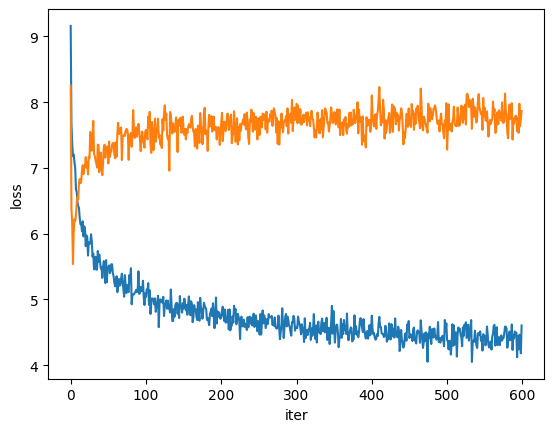

In [149]:
from matplotlib import pyplot as plt

vanilla_train = np.load("Logs/attention60000loss.npy")
vanilla_test = np.load("Logs/attention60000val.npy")
plt.plot(vanilla_train)
plt.plot(vanilla_test)
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()



# EVALUATION

Load all relevant models from their state dictionaries to run inference.

In [ ]:
hidden_size = 256

vanilla_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
vanilla_decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
vanilla_encoder.load_state_dict(torch.load("Checkpoints/Vanilla/encoder60000.pt"))
vanilla_decoder.load_state_dict(torch.load("Checkpoints/Vanilla/decoder60000.pt"))

attn_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p = 0.1).to(device)
attn_encoder.load_state_dict(torch.load("Checkpoints/Attention/attnencoder60000.pt"))
attn_decoder.load_state_dict(torch.load("Checkpoints/Attention/attndecoder60000.pt"))

ae_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
ae_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p = 0.1).to(device)
ae_encoder.load_state_dict(torch.load("Checkpoints/AE/encoder_fine_tune_60000.pt"))
ae_decoder.load_state_dict(torch.load("Checkpoints/AE/decoder_fine_tune_60000.pt"))


## Quantitative Evaluation

Here we define helper functions which allow us to easily calculate metrics for the ingredient recall, extra ingredients added, and use NLTK to calculate the BLEU and METEOR scores.

In [54]:
from nltk.translate import meteor
from nltk import word_tokenize


def calculate_metrics(ground_truth, prediction):
    ref_tokens = ground_truth.split()
    ref_tokens = [ref_tokens]
    bleu = sentence_bleu(ref_tokens, prediction)
    mt = meteor(ref_tokens, prediction)
    recall = ingredient_recall(ground_truth, prediction)
    extra = extra_ingredients(ground_truth, prediction, input_lang) # TODO: pass in the ingredient lang here
    # extra_ingredients = 
    return (bleu, mt, recall, extra)

#function to find the fraction of ingredients in the ground truth list which were included in the generated recipe
def ingredient_recall(ground_truth, prediction):
    recalled = 0
    gt = ground_truth.split()
    for i in gt:
        if i in prediction:
            recalled += 1
    return recalled/len(gt)

#function to find the fraction of ingredients which were wrongly generated (ie. not in the recipe specification)
def extra_ingredients(ground_truth, prediction, ingredient_lang):
    predicted_ingredients = [word for word in prediction if ingredient_lang.contains(word)]
    counting = 0
    for ing in predicted_ingredients:
        if ing not in ground_truth:
            counting += 1
    if len(predicted_ingredients) > 0:
        return counting/len(predicted_ingredients)
    return counting

<class 'function'>


In [51]:
def print_stats(bleu, meteor, recall, extras, model_name):
    print(model_name)
    bleu = sum(bleu)/len(bleu)
    meteor = sum(meteor)/len(meteor)
    recall = sum(recall)/len(recall)
    extras = sum(extras)/len(extras)
    print("BLEU: {}".format(bleu))
    print("Meteor: {}".format(meteor))
    print("Recall: {}".format(recall))
    print("Extra Ingredients: {}".format(extras))
    print('')

def evaluateModel1(encoder, decoder, data):
    bleu_scores = []
    meteor_scores = []
    recall_scores = []
    extra_scores = []
    for i in data:
        src = i[0]
        trg = i[1]
        output_words = evaluate(encoder, decoder, src)
        bleu, meteor, recall, extras = calculate_metrics(trg, prediction=output_words)
        bleu_scores.append(bleu)
        meteor_scores.append(meteor)
        recall_scores.append(recall)
        extra_scores.append(extras)
    print_stats(bleu_scores, meteor_scores, recall_scores, extra_scores, "Vanilla")
        

def evaluationStatsAttention(encoder, decoder, data):
    bleu_scores = []
    meteor_scores = []
    recall_scores = []
    extra_scores = []
    for i in data:
        src = i[0]
        trg = i[1]
        output_words, attn = test_attention(encoder, decoder, src)
        bleu, meteor, recall, extras = calculate_metrics(trg, prediction=output_words)
        bleu_scores.append(bleu)
        meteor_scores.append(meteor)
        recall_scores.append(recall)
        extra_scores.append(extras)
    print_stats(bleu_scores, meteor_scores, recall_scores, extra_scores, "Attention")

def evaluateAE(encoder, decoder, data):
    bleu_scores = []
    meteor_scores = []
    recall_scores = []
    extra_scores = []
    for i in data:
        src = i[0]
        trg = i[1]
        output_words, attn = test_attention(encoder, decoder, src)
        bleu, meteor, recall, extras = calculate_metrics(trg, prediction=output_words)
        bleu_scores.append(bleu)
        meteor_scores.append(meteor)
        recall_scores.append(recall)
        extra_scores.append(extras)
    print_stats(bleu_scores, meteor_scores, recall_scores, extra_scores, "Autoencoder")

def evaluateAlch(encoder, decoder, data):
    bleu_scores = []
    meteor_scores = []
    recall_scores = []
    extra_scores = []
    for i in data:
        src = i[0]
        trg = i[1]
        output_words = alchemy_inference(encoder, decoder, src, input_lang, output_lang)
        bleu, meteor, recall, extras = calculate_metrics(trg, prediction=output_words)
        bleu_scores.append(bleu)
        meteor_scores.append(meteor)
        recall_scores.append(recall)
        extra_scores.append(extras)
    print_stats(bleu_scores, meteor_scores, recall_scores, extra_scores, "Alchemy")

In [60]:
import warnings
warnings.filterwarnings("ignore")
nltk.download('wordnet')

evaluateModel1(vanilla_encoder, vanilla_decoder, test_pairs)
evaluationStatsAttention(attn_encoder, attn_decoder, test_pairs)
evaluateAE(ae_encoder, ae_decoder, test_pairs)
evaluateAlch(vanilla_encoder, vanilla_decoder, test_pairs)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Vanilla
BLEU: 0.002558684172777733
Meteor: 0.11101200697461412
Recall: 0.20035039509283883
Extra Ingredients: 0.6163472913669782

Attention
BLEU: 0.0016952848813750194
Meteor: 0.10252326012620815
Recall: 0.17207081577585795
Extra Ingredients: 0.66073387202814

Autoencoder
BLEU: 0.0010266232233851484
Meteor: 0.11708700109420117
Recall: 0.19441389598706196
Extra Ingredients: 0.6290507876177737

Alchemy
BLEU: 3.483796294264648e-05
Meteor: 0.05929738625690381
Recall: 0.15682296057934675
Extra Ingredients: 0.6147362561433746



## Qualitative Evaluation

Here I test the performance of my four models on two candidate ingredients lists supplied from Kiddon et. al.'s paper. The ingredients lists are as follows:
1. *"10 oz chopped broccoli, 2 tbsp butter, 2 tbsp flour, 1/2 tsp salt, 1/4 tsp black pepper, 1/4 tsp ground nutmeg, 1 cup milk, 1 1/2 cup shredded swiss cheese, 2 tsp lemon juice, 2 cup cooked cubed turkey, 4 oz mushrooms, 1/4 cup grated Parmesan cheese, 1 can refrigerated biscuits'*.
2.  *2 lb cream cheese, 1 3/4 cups sugar, 5 eggs, 15 oreo cookies, 1/2 tsp vanilla, 1/2 tsp almond extract*

I modify these recipes to suit the input format that the four models accept.

In [20]:
candidate_1 = "chopped broccoli butter flour salt black pepper ground nutmeg milk shredded swiss cheese lemon juice cooked cubed turkey mushrooms grated parmesan cheese refrigerated biscuits"
candidate_2 = "cream cheese sugar eggs oreo cookies vanilla almond extract"

In [32]:
print("Vanilla results:")
v1_words= evaluate(vanilla_encoder, vanilla_decoder, candidate_1)
v1_sentence = ' '.join(v1_words)
v2_words= evaluate(vanilla_encoder, vanilla_decoder, candidate_2)
v2_sentence = ' '.join(v2_words)
print("Recipe One: {}".format(v1_sentence))
print("Recipe Two: {}".format(v2_sentence))
print("")

print("Attention results:")
a1_words, atn = test_attention(attn_encoder, attn_decoder, candidate_1)
a1_sentence = ' '.join(a1_words)
a2_words, atn = test_attention(attn_encoder, attn_decoder, candidate_2)
a2_sentence = ' '.join(a2_words)
print("Recipe One: {}".format(a1_sentence))
print("Recipe Two: {}".format(a2_sentence))
print("")

print("Autoencoder results:")
ae1_words, atn = test_attention(ae_encoder, ae_decoder, candidate_1)
ae1_sentence = ' '.join(ae1_words)
ae2_words, atn = test_attention(ae_encoder, ae_decoder, candidate_2)
ae2_sentence = ' '.join(ae2_words)
print("Recipe One: {}".format(ae1_sentence))
print("Recipe Two: {}".format(ae2_sentence))
print("")

print("Alchemy results:")
al1_words = alchemy_inference(ae_encoder, ae_decoder, candidate_1, input_lang, output_lang)
al1_sentence = ' '.join(al1_words)
al2_words = alchemy_inference(ae_encoder, ae_decoder, candidate_2, input_lang, output_lang)
al2_sentence = ' '.join(al2_words)
print("Recipe One: {}".format(al1_sentence))
print("Recipe Two: {}".format(al2_sentence))

Vanilla results:
Recipe One: preheat oven f cut zucchini slices inch slices place bread slices bottom greased baking sheet sprinkle parmesan cheese bake minutes golden brown <EOS>
Recipe Two: preheat oven f cream butter sugar add eggs one time beating well addition add flour baking powder salt stir well blended add vanilla nuts mix well pour greased floured x inch loaf pan bake minutes cake tests done cool pan minutes remove pan cool completely cut squares <EOS>

Attention results:
Recipe One: heat oven f grease large baking dish combine onion green pepper onion green pepper onion garlic large bowl mix together remaining ingredients except cheese spread evenly bake minutes bubbly <EOS>
Recipe Two: mix ingredients together chill <EOS>

Autoencoder results:
Recipe One: melt butter large saucepan add onion celery saute tender add remaining ingredients except cheese stir well blended cover simmer minutes stirring occasionally stir cheese serve hot <EOS>
Recipe Two: combine sugar cornstarch